# Cleaning data

# 1. Inittial configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import os
import re

### Setting displays

In [2]:
pd.set_option('display.max_rows', 100) 
pd.set_option('display.max_columns', None) 
# pd.set_option('display.max_columns', None)  # Show all columns
# pd.set_option('display.max_rows', None)     # Show all rows
# pd.set_option('display.max_colwidth', None) # Show entire content of each column
pd.set_option('display.width', None)        # No limit on display width
pd.set_option('display.expand_frame_repr', False)  # Prevent wrapping

### Setting paths

In [3]:
# Setting paths
current_dir = os.getcwd()  # Use os.getcwd() to get the current working directory
parent_dir = os.path.dirname(current_dir)
data_dir = os.path.join(parent_dir, "data")
file_path = os.path.join(data_dir, "")
cars_csv_path = os.path.join(data_dir, "train.csv")
clean_data_car_csv_path = os.path.join(data_dir, "clean_data_car.csv")

# 2. Cleaning


### 2.1 Opening file
- reading raw data for cleaning

In [4]:
df_car = pd.read_csv(cars_csv_path)

In [5]:
df_car.sample(5)

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
154719,154719,Ford,Transit-350 XL,2021,195,Gasoline,310.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,A/T,White,Gray,None reported,Yes,45000
125051,125051,Toyota,Highlander Limited Platinum,2019,64500,Gasoline,270.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,A/T,White,Black,None reported,Yes,32500
165713,165713,Mercedes-Benz,AMG GT 63 S 4-Door,2021,16813,Gasoline,4.0L V8 32V GDI DOHC Twin Turbo,9-Speed Automatic,Obsidian Black Metallic,Beige,None reported,NaN,87500
9299,9299,Honda,Prelude Type SH,2001,125000,Gasoline,200.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,Silver,Black,At least 1 accident or damage reported,Yes,15400
97869,97869,Kia,Telluride EX,2019,69185,Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Glacial White Pearl,Black,None reported,NaN,27995


In [6]:
df_car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB


In [7]:
df_car.shape

(188533, 13)

### <span style="color:#fef377;"> Inspecting columns </span>

<span style="color:#ffc509;"> ["clean_title"] </span>
- unique value: "yes"
- column will be eliminated

It seems this was done by the original owner of the df to check something but since the only value there is, is "yes" it can be eliminated since it does not bring any value

In [8]:
df_car["clean_title"].nunique() # 1
df_car["clean_title"].unique() # ['Yes', nan]
df_car["clean_title"].isin(["NaN"]).sum() # np.int64(0)
df_car = df_car.drop("clean_title", axis = 1)

<span style="color:#ffc509;"> ["model_year"] </span>
- All values have 4 digits
- min value: 1974
- max value: 2024
- type of value is float, this will be change for int

In [9]:
df_car["model_year"].astype(str).str.len()[df_car["model_year"].astype(str).str.len() > 4]
df_car["model_year"].astype(str).str.len()[df_car["model_year"].astype(str).str.len() < 4]
df_car["model_year"].describe()
df_car["model_year"].isin(["NaN"]).sum() # np.int64(0)
df_car['model_year'] = df_car['model_year'].astype(int)
df_car['model_year'].dtype

dtype('int64')

<span style="color:#ffc509;">  ["fuel_type"] </span>
- 3 % of null

In [10]:
df_car["fuel_type"].nunique() # 7
df_car["fuel_type"].unique() # ['Gasoline', 'E85 Flex Fuel', nan, 'Hybrid', 'Diesel','Plug-In Hybrid', '–', 'not supported']
# ---------------------------------------------------------------------------------------------------------------------------
# The not valid values will be change for None so it can be analize for inferring
to_replace = [np.nan, '–', 'not supported']
df_car['fuel_type'] = df_car['fuel_type'].replace(to_replace, None)
# ---------------------------------------------------------------------------------------------------------------------------
percentage_null = (df_car['fuel_type'].isnull().sum() / len(df_car["fuel_type"])).round(2) * 100
percentage_null

np.float64(3.0)

<span style="color:#ffc509;">  ["transmission"] </span>

- 0 nulls but 
- 52 unique values

2 NEW COLUMNS will be made in order to see better if they are automatic, manual, both and the number of transmissiones

In [11]:
df_car["transmission"].isnull().sum() # np.int64(0)
df_car["transmission"].nunique() # 52
df_car["transmission"].unique() # 
df_car[df_car["transmission"] == "Single-Speed Fixed Gear"] # There are higly speed cars and by ramdomnly checking, these cars are AUTOMATIC
df_car[df_car["transmission"] == "F"] # 65 lines, by checking randomnly 8 different models of different brands, we can see they are AUTOMATIC
df_car[df_car["transmission"] == "–"] # 87 values
df_car[df_car["transmission"] == "2"] # 91
df_car[df_car["transmission"] == "7-Speed"] # 29
df_car[df_car["transmission"] == "Variable"] # 66
df_car[df_car["transmission"] == "6-Speed"] # 27

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,price
20510,20510,BMW,435 i,2014,85385,Gasoline,300.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,6-Speed,Black,Beige,None reported,15499
42067,42067,Toyota,Tacoma TRD Pro,2019,40698,Gasoline,3.5L V6 24V PDI DOHC,6-Speed,Super White,Black,None reported,34955
43398,43398,Toyota,Tacoma TRD Pro,2018,48156,Gasoline,3.5L V6 24V PDI DOHC,6-Speed,Midnight Black Metallic,Black/Gun Metal,None reported,46750
49841,49841,Toyota,Tacoma TRD Pro,2018,39948,Gasoline,3.5L V6 24V PDI DOHC,6-Speed,Super White,Graphite,None reported,26691
56243,56243,Toyota,Tacoma TRD Sport,2021,41500,Gasoline,3.5L V6 24V PDI DOHC,6-Speed,Gray,Black,None reported,46000
58020,58020,Toyota,Tacoma TRD Pro,2020,26540,Gasoline,3.5L V6 24V PDI DOHC,6-Speed,Blue,Black,None reported,38995
67455,67455,Toyota,Tacoma TRD Pro,2021,25083,Gasoline,3.5L V6 24V PDI DOHC,6-Speed,–,Black,None reported,38781
68572,68572,GMC,Acadia SLE-1,2022,13700,Gasoline,228.0HP 2.4L 4 Cylinder Engine Gasoline Fuel,6-Speed,Black,Black,None reported,55329
73279,73279,Toyota,Tacoma TRD Pro,2020,26468,Gasoline,3.5L V6 24V PDI DOHC,6-Speed,Super White,Black,None reported,39985
73469,73469,Toyota,Tacoma TRD Sport,2020,53433,Gasoline,3.5L V6 24V PDI DOHC,6-Speed,Black,Black,None reported,28495


<span style="color:#ffc509;">  ["transmission_types"] </span>

- Only 0.16% are others

In [12]:
def transmission_types(transmission_string):
    transmission_lower = str(transmission_string).lower()
    if ("at/mt" in transmission_lower  
        or "dual" in transmission_lower 
        or "auto-shift" in transmission_lower 
        or "overdrive switch" in transmission_lower):  
        return "Dual" # When they are both and can passed from automatic to manual and viceversa
    elif ('automatic' in transmission_lower 
          or 'at' in transmission_lower 
          or 'a/t' in transmission_lower 
          or 'cvt' in transmission_lower 
          or 'dct' in transmission_lower 
          or 'single-speed fixed gear' in transmission_lower 
          or 'f' in transmission_lower):
        return 'Automatic'
    elif 'manual' in transmission_lower or 'm/t' in transmission_lower or 'mt' in transmission_lower:
        return 'Manual'
    else:
        return 'Other' # The rest

df_car['transmission_types'] = df_car['transmission'].apply(transmission_types)

In [13]:
(df_car["transmission_types"].value_counts(normalize=True) * 100).round(2)

transmission_types
Automatic    79.85
Dual         11.30
Manual        8.70
Other         0.16
Name: proportion, dtype: float64

<span style="color:#ffc509;">  ["transmission_num"] </span>

- null: 44.71%

In [14]:
def extract_transmission_number(transmission_string):
    if pd.isna(transmission_string):  
        return None # If there are no numbers on the row, then return None
    match = re.search(r"\d+", str(transmission_string)) # This extracts the letters
    return match.group(0) if match else None

df_car['transmission_num'] = df_car['transmission'].apply(extract_transmission_number) # Create a new column

In [15]:
df_car['transmission_num'] = pd.to_numeric(df_car['transmission_num'], errors='coerce').astype('Int64')

In [16]:
(df_car["transmission_num"].isnull().sum() / len(df_car["transmission_num"]) * 100).round(2) # 44.71%
(df_car["transmission_num"].value_counts(normalize=True) * 100).round(2)

transmission_num
6     31.92
8     28.46
7      12.5
10    10.79
9      5.97
5      5.55
4      2.49
1      2.14
2      0.18
Name: proportion, dtype: Float64

In [17]:
df_car['transmission_num'].value_counts()

transmission_num
6     33278
8     29673
7     13027
10    11248
9      6224
5      5785
4      2594
1      2234
2       184
Name: count, dtype: Int64

<span style="color:#ffc509;">  ["accident"] </span>

- null: 1.3%
- unique values: 2 None, None reported and At least one accident

Column will be changed to boolean being 1 = accident and 0 = none reported / none

By reading None is there are no values, we will interpret this as if there are no values then there are no reports of accidents

In [18]:
def accident_turn_boolean(accident_string):
    if pd.isna(accident_string):
        return False   # if nan, this will be false = no accident reported
    elif "At least 1 accident or damage reported" in accident_string:
        return True    # This will turn one = there are accidents reported
    else:
        return False# if none reported which is left, this will be false = no accident reported

df_car['accident'] = df_car['accident'].apply(accident_turn_boolean)

<span style="color:#ffc509;">  ["engine"] </span>

-  The information is mixed up in the cell
-  The "-" will be replaced by "Unknown"
-  The liters will be extracted
    - Then converted to cubic centimeters
    - NEW COLUMN made to store only the data in float type <span style="color:#ffc509;">  ["engine_cc"] </span>

In [19]:
df_car["engine"].isnull().sum() # 0
(df_car["engine"].isnull().sum() / len(df_car["engine"]) * 100).round(2) # 0%
(df_car["engine"].value_counts(normalize=True) * 100).round(2) #
df_car["engine"].nunique() # 1117
df_car["engine"].unique() # 
df_car["engine"].str.contains("Cylinder").value_counts() # 37855 FALSE
df_car[df_car["engine"] == "example"]  #
df_car["engine"].sample(5)

100457    230.0HP 3.0L Straight 6 Cylinder Engine Gasoli...
2565                                  3.6L V6 24V MPFI DOHC
128088         717.0HP 6.2L 8 Cylinder Engine Gasoline Fuel
93645         290.0HP 3.5L V6 Cylinder Engine Gasoline Fuel
11929         365.0HP 3.5L V6 Cylinder Engine Gasoline Fuel
Name: engine, dtype: object

<span style="color:#ffc509;">  ["engine_cc"] </span>

- 4% of nulls

In [20]:
def extract_liters_to_cubic_cm(row):
   
    engine_string = str(row['engine'])
    engine_lower = engine_string.lower()
    if pd.isna(engine_string):
        return None

    match = re.search(r"(\d\.?\d*)L", engine_string)  # Only extract what it is only before L which indicates the liters
    match_2 = re.search(r"\s*(\d\.?\d*)\s+liter", engine_lower)  # Extract number before ' liter'
    match_3 =  re.search(r"(\d\.?\d*)\s+L\w*", engine_string) # Extract number before ' L' followed by other characters

    if match:
        try:
            liters_str = match.group(1)
            liters = float(liters_str)
            cubic_cm = liters * 1000
            return cubic_cm
        except ValueError:
            return None
    elif match_2:
        try:
            liters_str = match_2.group(1)
            liters = float(liters_str)
            cubic_cm = liters * 1000
            return cubic_cm
        except ValueError:
            return None
    elif match_3:
        try:
            liters_str = match_3.group(1)
            liters = float(liters_str)
            cubic_cm = liters * 1000
            return cubic_cm
        except ValueError:
            return None
    else:
        return None

df_car['engine_cc'] = df_car.apply(extract_liters_to_cubic_cm, axis=1) # Apply row-wise
print(df_car[['engine', 'engine_cc']].head())

                                              engine  engine_cc
0       172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel     1600.0
1       252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel     3900.0
2  320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...     5300.0
3       420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel     5000.0
4       208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel     2000.0


In [21]:
df_car["engine_cc"].dtype

dtype('float64')

In [23]:
percentage_null = (df_car['engine_cc'].isnull().sum() / len(df_car["engine_cc"])).round(2) * 100
percentage_null # 4%
checking_nulls_engine_cc = df_car[df_car["engine_cc"].isnull()]["engine"]
checking_nulls_engine_cc.sample(10)


151782    563.0HP Electric Motor Electric Fuel System
144625    271.0HP Electric Motor Electric Fuel System
98021                                               –
85508     534.0HP Electric Motor Electric Fuel System
152304                             12 Cylinder Engine
127197    518.0HP Electric Motor Electric Fuel System
19215     670.0HP Electric Motor Electric Fuel System
108124            Electric Motor Electric Fuel System
46708     375.0HP Electric Motor Electric Fuel System
160256    455.0HP Electric Motor Electric Fuel System
Name: engine, dtype: object

### <span style="color:#fef377;">  Checking duplicates </span>
- There are none

In [25]:
df_car.duplicated().sum()

np.int64(0)

### <span style="color:#fef377;">  Re arranging columns </span>

In [26]:
df_car = df_car[["id", "brand", "model", "model_year", "milage", "fuel_type", "engine", "engine_cc", 
                 "transmission", "transmission_types", "transmission_num","ext_col", "int_col", "accident", "price"]]

### <span style="color:#fef377;"> Checking outliers </span>

- <span style="color:#ffc509;">  ["milage"] </span> : 
- <span style="color:#ffc509;">  ["price"] </span>: The boxplot for 'price' shows a concentration of values at the lower end, with a large number of significant outliers extending towards much higher prices.

In [27]:
# Calculating inter quantile range of columns
def detect_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR # outliers under the range
    upper_bound = Q3 + 1.5 * IQR # outliers above the range
    outliers = (series < lower_bound) | (series > upper_bound)
    return outliers # only lower and upper outliers will be shown

# -------------------------------------------------------------------------------------------------
# Checking the percentages of the outliers
def percentage_outliers(df):
    outliers_percentage = {}
    for column in df.select_dtypes(include=np.number).columns:
        outliers = detect_outliers_iqr(df[column])
        percentage = outliers.sum() / len(df) * 100
        outliers_percentage[column] = f'{percentage:.2f}%'
    return outliers_percentage

percentage_outliers_df = percentage_outliers(df_car)
print(f"Outliers percentages per column:\n{percentage_outliers_df}") # This shows only the "real" outliers

Outliers percentages per column:
{'id': '0.00%', 'model_year': '2.72%', 'milage': '0.94%', 'engine_cc': '0.17%', 'transmission_num': '1.28%', 'price': '5.77%'}


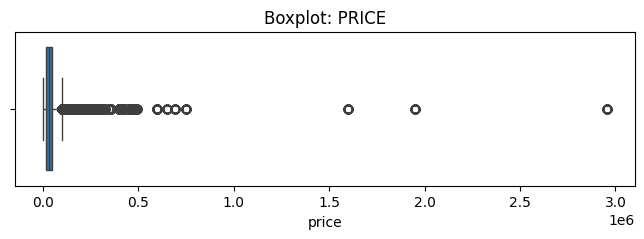

In [28]:
def plot_boxplot(df, columna):
    plt.figure(figsize=(8, 2))
    sns.boxplot(x=df[columna])
    plt.title(f'Boxplot: {columna.upper()}')
    plt.xlabel(columna)
    plt.show()

plot_boxplot(df_car, 'price')

### <span style="color:#fef377;">  Checking column's distribuition </span>

- <span style="color:#ffc509;">  ["price"] </span> : The price distribution is heavily right-skewed with a high frequency of lower-priced vehicles and a long tail indicating a smaller number of significantly higher-priced outliers.

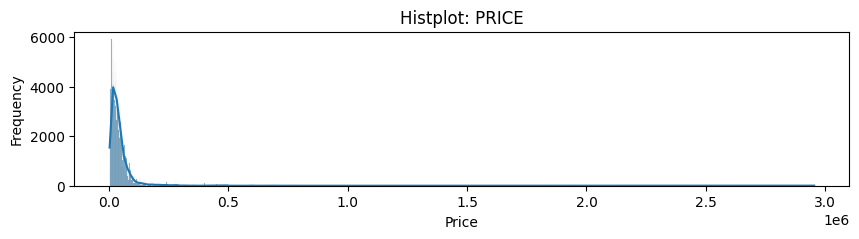

In [29]:
# Checking the distribuition of data
def plot_histplot(df, columna):
    plt.figure(figsize=(10, 2))
    sns.histplot(df_car['price'], kde=True)
    plt.title(f'Histplot: {columna.upper()}')
    plt.xlabel('Price') # Checking this column
    plt.ylabel('Frequency')
    plt.show()
plot_histplot(df_car, 'price')

#### Checking column:
<span style="color:#ffc509;">  ["price"] </span>
- By checking the top prices I can see there are block of prices regardless of the model, milage, engine and other columns
    - By sorting the prices descendant, I can see blocks of prices likely not to be true
- By checking the block prices in the original sort, I can can see there are no blocks
- By checking with z score, there are a lot of outliers than can significantly change the prediction model

In [30]:
# First let's check the top pricy cars
df_car_sorted_price_desc = df_car.sort_values(by='price', ascending=False)
df_car_sorted_price_desc

,id,brand,model,model_year,milage,fuel_type,engine,engine_cc,transmission,transmission_types,transmission_num,ext_col,int_col,accident,price
14693,14693,Hyundai,Santa Fe SEL,2022,13865,Gasoline,2.5L I4 16V PDI DOHC,2500.0,8-Speed Automatic,Automatic,8,Black,Black,False,2954083
1880,1880,Chrysler,300C Base,2003,55900,Gasoline,340.0HP 5.7L 8 Cylinder Engine Gasoline Fuel,5700.0,5-Speed A/T,Automatic,5,Beige,Beige,False,2954083
65043,65043,Mercedes-Benz,AMG GLE AMG GLE 63 S-Model 4MATIC,2017,4590,Gasoline,577.0HP 5.5L 8 Cylinder Engine Gasoline Fuel,5500.0,Transmission w/Dual Shift Mode,Dual,<NA>,Gray,Black,False,2954083
103061,103061,RAM,1500 Classic Warlock,2019,36757,Gasoline,5.7L V8 16V MPFI OHV,5700.0,8-Speed Automatic,Automatic,8,Diamond Black,Diesel Gray / Black,False,2954083
59650,59650,Toyota,Highlander XLE,2022,13566,Gasoline,2.4L I4 16V PDI DOHC Turbo,2400.0,8-Speed Automatic,Automatic,8,Ruby Flare Pearl,Black,False,2954083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758,758,Pontiac,Firebird Trans Am,2001,150000,Gasoline,310.0HP 5.7L 8 Cylinder Engine Gasoline Fuel,5700.0,A/T,Automatic,<NA>,Black,Beige,False,2000
128877,128877,Hyundai,Tucson SE,2007,16200,Gasoline,173.0HP 2.7L V6 Cylinder Engine Gasoline Fuel,2700.0,A/T,Automatic,<NA>,Silver,Gray,False,2000
121877,121877,Mercedes-Benz,CLK-Class 500 Cabriolet,2001,127131,Gasoline,302.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,5000.0,A/T,Automatic,<NA>,Silver,Black,True,2000
31264,31264,Volkswagen,Golf GTI 2.0T SE 4-Door,2012,132000,Gasoline,210.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,2000.0,6-Speed M/T,Manual,6,White,Black,False,2000


In [31]:
# Identify rows where the price is the same as the previous row
price_same_as_previous = df_car['price'] == df_car['price'].shift(1)
count_same_prices = price_same_as_previous.sum()
print(f"Number of rows with the same price as the previous row: {count_same_prices}")

Number of rows with the same price as the previous row: 400


In [32]:
# Let's check if the prices are repeated in blocks of X qty <--- by checking: 50=0   20=0  10=0   5=0
block_size = 5
num_rows = len(df_car)
suspicious_rows = 0
for i in range(0, num_rows - block_size, block_size):
    first_price_block = df_car['price'].iloc[i]
    uniform_price = (df_car['price'].iloc[i:i + block_size] == first_price_block).all()
    if uniform_price:
        suspicious_rows += block_size
print(f"Estimated number of rows in blocks of {block_size} with uniform price: {suspicious_rows}")

Estimated number of rows in blocks of 5 with uniform price: 0


In [33]:
prices = df_car['price'].values
changes = np.where(prices[:-1] != prices[1:])[0] + 1
length = np.diff(np.concatenate(([0], changes, [len(prices)])))
print("Length of identical prices repeated", np.unique(length, return_counts=True))
# 187,735 lines that do not repeat the price
# 396 times the price is repeated twice in a row
#  2 times the price is repeated three times in a row

Length of identical prices repeated (array([1, 2, 3]), array([187735,    396,      2]))


In [34]:
# Checking the top 5 most repeated prices
prices_count = df_car['price'].value_counts() # 15000 repeated 1920 times | 12000 repeated 1459 times |30000 repeated 1280 times|29000 repeated 1228 times|8500 repeated 1204 times
prices_count.head()

price
15000    1920
12000    1459
30000    1280
29000    1228
8500     1204
Name: count, dtype: int64

Original DataFrame size: 188533
DataFrame size after removing suspicious prices: 181442


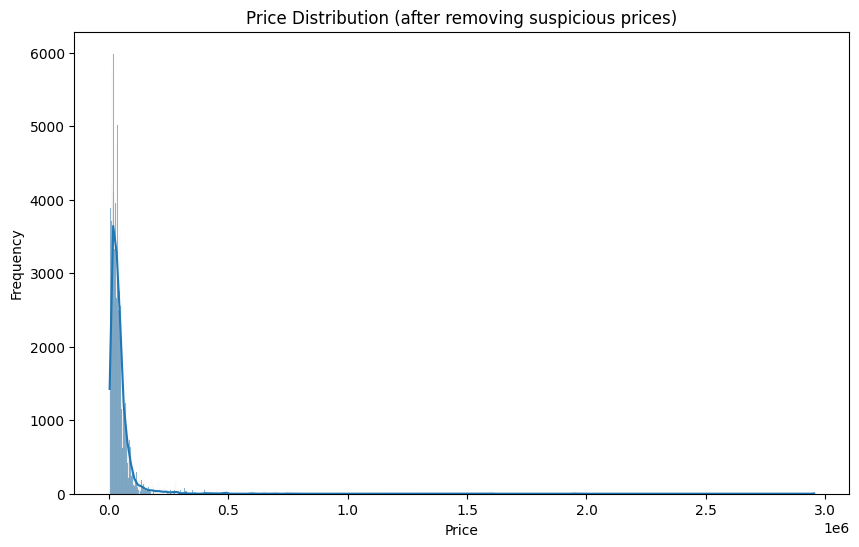

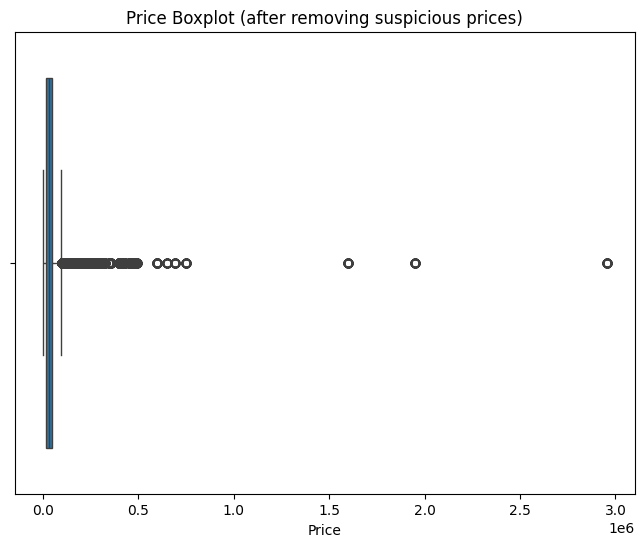

In [35]:
suspicious_prices = prices_count.head(5).index.tolist() 
df_car_checking = df_car[~df_car['price'].isin(suspicious_prices)]
print(f"Original DataFrame size: {len(df_car)}")
print(f"DataFrame size after removing suspicious prices: {len(df_car_checking)}")

# Re-analyze the price distribution in df_car_checking
plt.figure(figsize=(10, 6))
sns.histplot(df_car_checking['price'], kde=True)
plt.title('Price Distribution (after removing suspicious prices)')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(x=df_car_checking['price'])
plt.title('Price Boxplot (after removing suspicious prices)')
plt.xlabel('Price')
plt.show()

In [36]:
def identify_distant_zscore_outliers(series, threshold=3):
  
    z = np.abs(stats.zscore(series))
    distant_outliers = series[z > threshold].sort_values()
    return distant_outliers

threshold_value = 3  # Define the threshold value here

for column in df_car.select_dtypes(include=np.number).columns:
    distant_outliers = identify_distant_zscore_outliers(df_car[column], threshold=threshold_value)
    if not distant_outliers.empty:
        print(f"Distant outliers (Z-score > {threshold_value}) in column '{column}':")
        print(distant_outliers)

Distant outliers (Z-score > 3) in column 'model_year':
8173     1974
55169    1974
38565    1974
47488    1974
60702    1974
         ... 
4317     1998
3675     1998
3011     1998
2657     1998
461      1998
Name: model_year, Length: 1204, dtype: int64
Distant outliers (Z-score > 3) in column 'milage':
54832     217000
85699     217000
92470     217400
140381    217500
107858    217500
           ...  
61730     405000
45077     405000
36080     405000
24014     405000
45288     405000
Name: milage, Length: 1200, dtype: int64
Distant outliers (Z-score > 3) in column 'price':
5743       288900
82395      288900
86178      288900
120743     288900
180681     288900
           ...   
89180     2954083
181021    2954083
84731     2954083
65043     2954083
85611     2954083
Name: price, Length: 1315, dtype: int64


In [37]:
mean_price = df_car['price'].mean()

outliers_price = df_car[np.abs(stats.zscore(df_car['price'])) > 3]['price']
outliers_price_high = outliers_price[outliers_price >= mean_price]
outliers_price_low = outliers_price[outliers_price < mean_price]

print(f"QTY of outliers with highly prices: {len(outliers_price_high)}") # 1315
print(f"QTY of outliers with low price: {len(outliers_price_low)}") # 0

print(f"Outliers with high prices: {outliers_price_high.head()}") #
print(f"Outliers with low prices: {outliers_price_low.head()}") # 0

QTY of outliers with highly prices: 1315
QTY of outliers with low price: 0
Outliers with high prices: 220    2954083
267     315000
296     489000
350     349950
433     449995
Name: price, dtype: int64
Outliers with low prices: Series([], Name: price, dtype: int64)


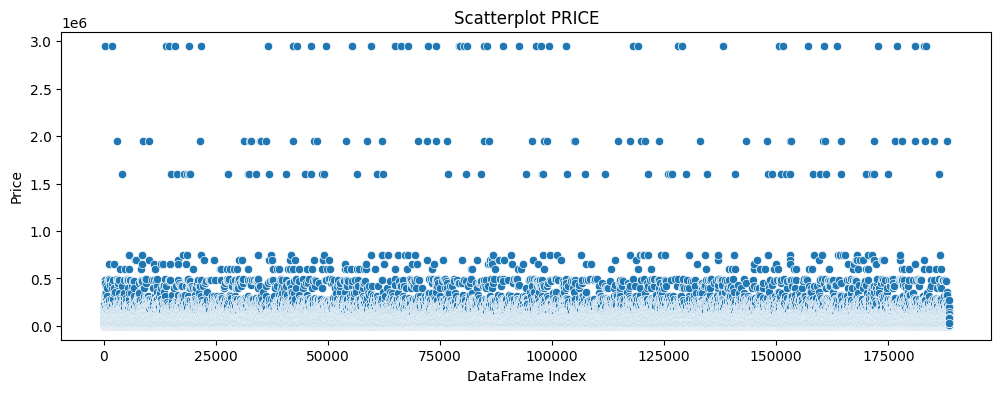

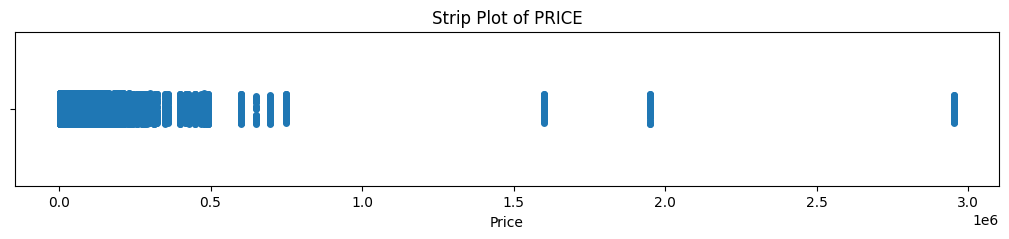

In [38]:
plt.figure(figsize=(12, 4))
sns.scatterplot(x=df_car.index, y=df_car['price'])
plt.title('Scatterplot PRICE')
plt.xlabel('DataFrame Index')
plt.ylabel('Price')
plt.show()

# Otra opción con strip plot
plt.figure(figsize=(12.7, 2))
sns.stripplot(x='price', data=df_car, jitter=True) # jitter añade dispersión para ver puntos superpuestos
plt.title('Strip Plot of PRICE')
plt.xlabel('Price')
plt.show()

Dataframe size of column price WITH outliers: 188533
Dataframe size of column price withOUT outliers: 187218


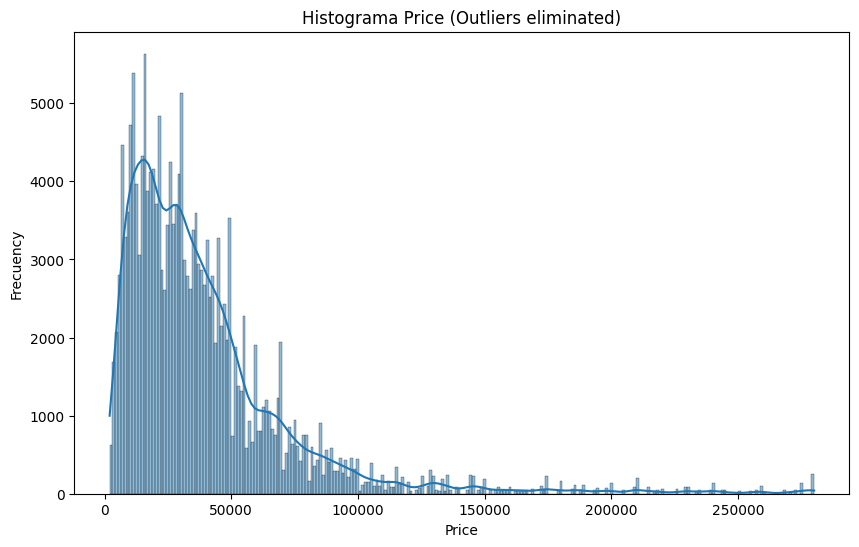

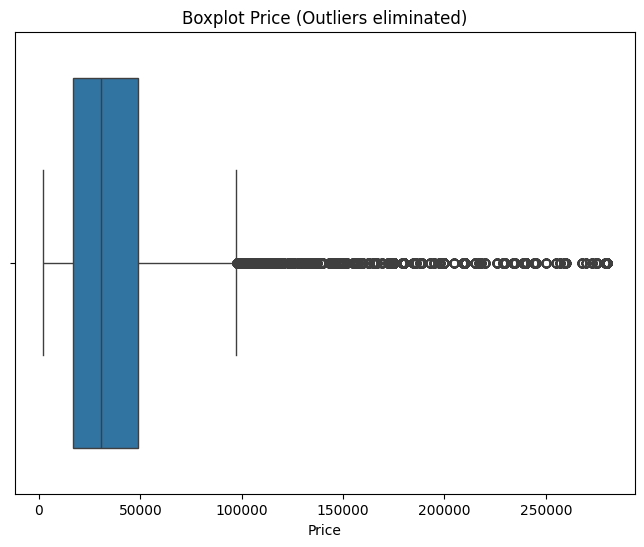

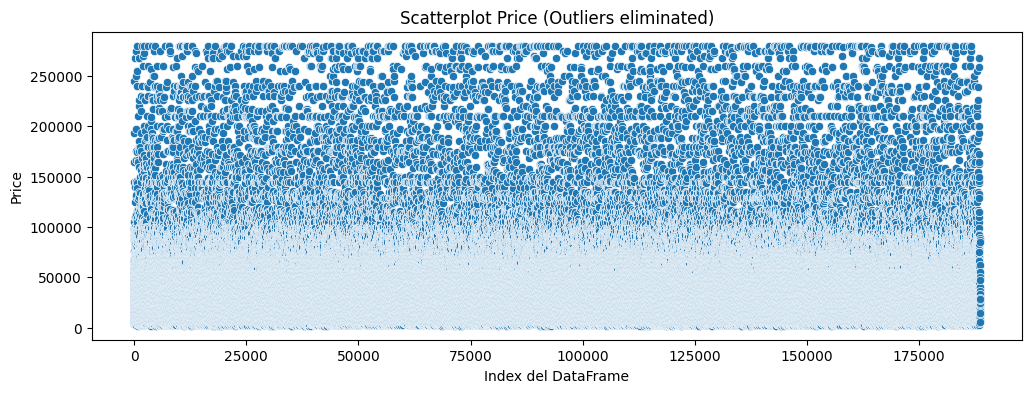

In [39]:
# Identificar los índices de los outliers de 'price'
outlier_index_price = df_car[np.abs(stats.zscore(df_car['price'])) > 3].index

# Crear un DataFrame sin estos outliers
df_car_without_ouliers_price = df_car.drop(outlier_index_price)

print(f"Dataframe size of column price WITH outliers: {len(df_car)}")
print(f"Dataframe size of column price withOUT outliers: {len(df_car_without_ouliers_price)}")


plt.figure(figsize=(10, 6))
sns.histplot(df_car_without_ouliers_price['price'], kde=True)
plt.title('Histograma Price (Outliers eliminated)')
plt.xlabel('Price')
plt.ylabel('Frecuency')
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(x=df_car_without_ouliers_price['price'])
plt.title('Boxplot Price (Outliers eliminated)')
plt.xlabel('Price')
plt.show()

plt.figure(figsize=(12, 4))
sns.scatterplot(x=df_car_without_ouliers_price.index, y=df_car_without_ouliers_price['price'])
plt.title('Scatterplot Price (Outliers eliminated)')
plt.xlabel('Index del DataFrame')
plt.ylabel('Price')
plt.show()

C:\Users\yaelp\AppData\Local\Temp\ipykernel_3084\2415878153.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_car.drop(outlier_index_price, inplace=True)


Original DataFrame size (before removing price outliers): 188533
DataFrame size after removing price outliers: 187218


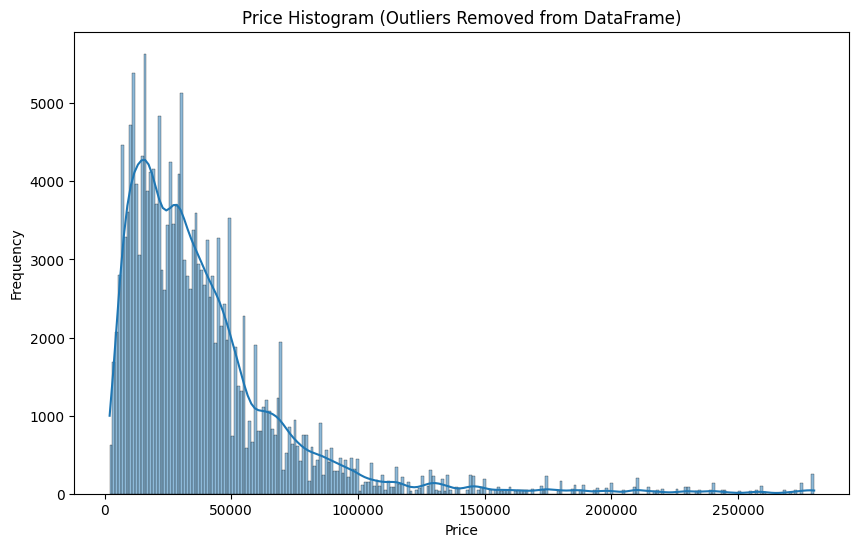

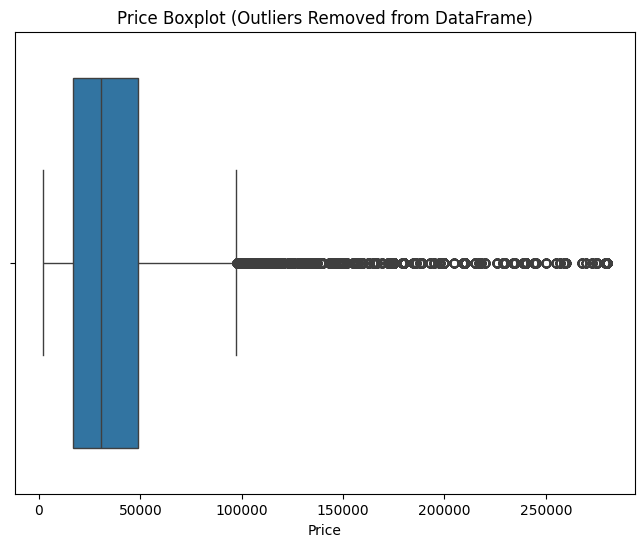

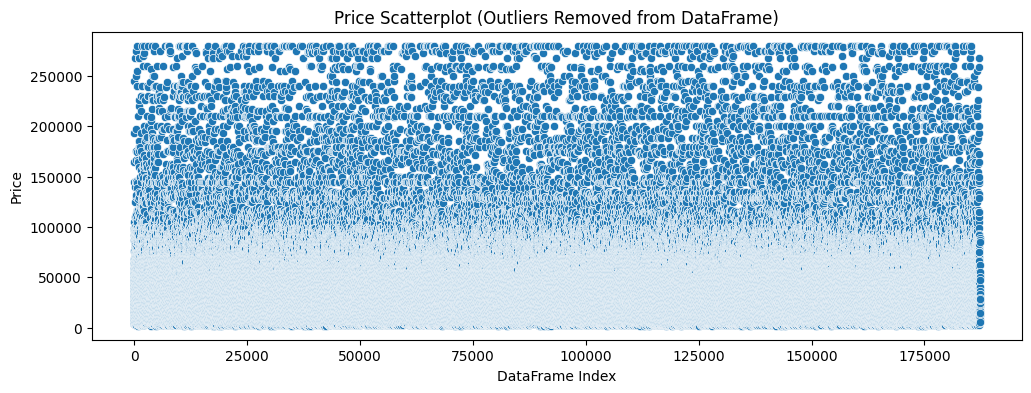

In [40]:
# Eliminating outliers
outlier_index_price = df_car[np.abs(stats.zscore(df_car['price'])) > 3].index

# Drop the rows corresponding to these indices from the original DataFrame
df_car.drop(outlier_index_price, inplace=True)

# Reset the DataFrame index after removal
df_car.reset_index(drop=True, inplace=True)

print(f"Original DataFrame size (before removing price outliers): {len(df_car) + len(outlier_index_price)}")
print(f"DataFrame size after removing price outliers: {len(df_car)}")

# Checking again de graphics

plt.figure(figsize=(10, 6))
sns.histplot(df_car['price'], kde=True)
plt.title('Price Histogram (Outliers Removed from DataFrame)')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(x=df_car['price'])
plt.title('Price Boxplot (Outliers Removed from DataFrame)')
plt.xlabel('Price')
plt.show()

plt.figure(figsize=(12, 4))
sns.scatterplot(x=df_car.index, y=df_car['price'])
plt.title('Price Scatterplot (Outliers Removed from DataFrame)')
plt.xlabel('DataFrame Index')
plt.ylabel('Price')
plt.show()

### <span style="color:#fef377;">  Saving CSV </span>

In [41]:
df_car.to_csv(clean_data_car_csv_path, index=False)

if os.path.exists(clean_data_car_csv_path):
    print("File succesfully saved.")
    print(f" File size: {os.path.getsize(clean_data_car_csv_path) / 1024:.2f} KB")
else:
    print("⚠️ Error while saving file.")

File succesfully saved.
 File size: 27206.37 KB


__________
_________

### <span style="color:#fef377;"> Resumen Limpieza: </span>

Se han creado nuevas columnas para optimizar la visualización de cara al futuro modelo de predicción así coomo cambios ligeros de tipo dentro de las restantes.

<u> Por columnas: </u>

- price: Se eliminaros los outliers alejados.

<u> Diccionario: </u>


| Nombre Columna        | Tipo Columna   | Significado Columna                                                      |
|-----------------------|----------------|--------------------------------------------------------------------------|
| id                    | int64          | Número identificativo de cada entrada                                    |
| brand                 | object         | Nombre de la marca del vehículo                                          |
| model                 | object         | Nombre del modelo del vehículo                                           |
| model_year            | int64          | Año de lanzamiento del modelo por la marca                               |
| milage                | int64          | Cantidad de millas recorridas por el vehículo                            |
| fuel_type             | object         | Especifica el tipo de combustible del vehículo                            |
| engine                | object         | Especifica el tipo de motor del vehículo                                |
| transmission          | object         | Datos originales de la caja de cambios del vehículo                      |
| transmission_types    | object         | Tipo de transmisión (automática, dual, manual, otros)                    |
| transmission_num      | Int64          | Cantidad de marchas del vehículo (cuando información disponible)         |
| ext_col               | object         | Color exterior del vehículo                                              |
| int_col               | object         | Color interior del vehículo                                              |
| accident              | bool           | Booleano que señala si se reportó un accidente (1=Sí)                   |
| price                 | int64          | Precio de venta del vehículo                                             |